# Prueba de evaluación contiua 2
- Autor: Juan A. García Cuevas
- Fecha: 16/10/2016

# Parte 2
En esta segunda parte trabajaremos con información en XML. Concretamente, el gobierno británico nos ofrece datasets sobre eventos de tráfico:

https://data.gov.uk/dataset/live-traffic-information-from-the-highways-agency-road-network

Trabajaremos con los “Unplanned Events” que se proporcionan en un formato XML. Se puede descargar de esta URL:

http://hatrafficinfo.dft.gov.uk/feeds/datex/England/UnplannedEvent/content.xml

Concretamente, contiene un conjunto de situaciones (“situation”) y dentro de la descripción de las situaciones, nos interesa el impacto (“impact”).

Investiga el impacto de los eventos no planificados en las variables que aporten algo de información. Por ejemplo, la variable “capacityRemaining” indica la capacidad de la vía que la situación dejó sin afectar, y en ocasiones indica obstrucción total (valor 0.0) pero en otros casos sólo parcial. Estudia descriptivamente al menos 3 de las variables, sean numéricas o categóricas, dentro de las que describen el impacto solamente.

 # Resolución

In [1]:
# Importamos librerías

# Librería para descarga de información de internet
from urllib import urlretrieve, urlcleanup
# Librería de tratamiento de XML
from lxml import objectify
# Librería Pandas
import pandas as pd

# Para que los gráficos se muesyrane n el notebook
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# Descargamos el fichero XML de internet
xmlUrl = 'http://hatrafficinfo.dft.gov.uk/feeds/datex/England/UnplannedEvent/content.xml'
xmlPath = 'TraficUnplannedEvents.xml'
urlretrieve(xmlUrl, xmlPath)
urlcleanup()

In [3]:
# Comprobamos que el fichero XML ha sido grabado en el disco local
print 'FICHERO:'
print '========'
%ls -l $xmlPath
print ''
print 'CONTENIDO DEL FICHERO:'
print '======================'
!head $xmlPath

FICHERO:
-rw-rw-r-- 1 juan juan 23235 oct 16 15:25 TraficUnplannedEvents.xml

CONTENIDO DEL FICHERO:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?><d2LogicalModel xmlns="http://datex2.eu/schema/1_0/1_0" modelBaseVersion="1.0"><exchange><supplierIdentification><country>gb</country><nationalIdentifier>NTCC</nationalIdentifier></supplierIdentification></exchange><payloadPublication xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:type="SituationPublication" lang="en"><publicationTime>2015-12-07T19:40:48Z</publicationTime><publicationCreator><country>gb</country><nationalIdentifier>NTCC</nationalIdentifier></publicationCreator><situation id="GUID732336731"><headerInformation><areaOfInterest>national</areaOfInterest><confidentiality>restrictedToAuthoritiesTrafficOperatorsAndPublishers</confidentiality><informationUsage>broadcast</informationUsage><informationStatus>real</informationStatus></headerInformation><situationRecord xsi:type="MaintenanceWorks" id="GUID1-732336738"

In [4]:
# Cargamos el fichero XML en memoria
xmlDoc = objectify.parse(xmlPath)
raiz = xmlDoc.getroot()

print 'Elemento raiz del árbol XML:'
print '- nombre.....:', raiz.tag
print '- atributos..:', raiz.attrib
print '- nº de hijos:', raiz.countchildren()

Elemento raiz del árbol XML:
- nombre.....: {http://datex2.eu/schema/1_0/1_0}d2LogicalModel
- atributos..: {'modelBaseVersion': '1.0'}
- nº de hijos: 2


In [5]:
# Cargamos los datos que nos interesan en un conjunto de vectores
impactOnTraffic = []
capacityRemaining = []
numberOfLanesRestricted = []
numberOfOperationalLanes = []
originalNumberOfLanes = []
trafficRestrictionType = []
delayTimeValue = []
situationRecordVersion = []
for row in raiz.payloadPublication.situation:
    impactOnTraffic.append(row.situationRecord.impact.impactOnTraffic.text)
    capacityRemaining.append(row.situationRecord.impact.impactDetails.capacityRemaining.text)
    numberOfLanesRestricted.append(row.situationRecord.impact.impactDetails.numberOfLanesRestricted.text)
    numberOfOperationalLanes.append(row.situationRecord.impact.impactDetails.numberOfOperationalLanes.text)
    originalNumberOfLanes.append(row.situationRecord.impact.impactDetails.originalNumberOfLanes.text)
    trafficRestrictionType.append(row.situationRecord.impact.impactDetails.trafficRestrictionType.text)
    delayTimeValue.append(row.situationRecord.impact.delays.delayTimeValue.text)
    situationRecordVersion.append(row.situationRecord.situationRecordVersion.text)

In [6]:
# Creamos un dataframe con los datos (convirtiendo el tipo los que sea necesario)
data = pd.DataFrame()
data['impactOnTraffic'] = impactOnTraffic
data['capacityRemaining'] = pd.Series(capacityRemaining, dtype="float")
data['numberOfLanesRestricted'] = pd.Series(numberOfLanesRestricted, dtype="int32")
data['numberOfOperationalLanes'] = pd.Series(numberOfOperationalLanes, dtype="int32")
data['originalNumberOfLanes'] = pd.Series(originalNumberOfLanes, dtype="int32")
data['trafficRestrictionType'] = trafficRestrictionType
data['delayTimeValue'] = pd.Series(delayTimeValue, dtype="float")
data['situationRecordVersion'] = pd.Series(situationRecordVersion, dtype="int32")

# Mostramos el nuevo dataframe
print data.shape
data.head()

(6, 8)


,impactOnTraffic,capacityRemaining,numberOfLanesRestricted,numberOfOperationalLanes,originalNumberOfLanes,trafficRestrictionType,delayTimeValue,situationRecordVersion
0,heavy,75.0,1,3,4,carriagewayPartiallyObstructed,600.0,44
1,impossible,0.0,2,0,2,carriagewayBlocked,900.0,15
2,impossible,0.0,1,0,1,carriagewayBlocked,600.0,6
3,impossible,0.0,1,0,1,carriagewayBlocked,0.0,1
4,impossible,0.0,1,0,1,carriagewayBlocked,0.0,1


Se quiere analizar el impacto de los eventos no planificados en la fluidez del tráfico.

La variable categórica será la que indica el impacto en el tráfico (impactOnTraffic).

El número de carriles restringidos (numberOfLanesRestricted) es una combinación del número de carriles totales (originalNumberOfLanes) y el de carriles disponibles (numberOfOperationalLanes), por lo que estas tres variables pueden reducirse en una: numberOfOperationalLanes.

Por otro lado, el número de carriles disponibles está relacionado con la capacidad de tráfico restante (capacityRemaining) y el tipo de restricción (trafficRestrictionType), por lo que podemos eliminar también dos de ellas.

Al final, nos quedaremos con la variable capacityRemaining y eliminaremos las variables dependientes: numberOfLanesRestricted, numberOfOperationalLanes, originalNumberOfLanes y trafficRestrictionType.

In [7]:
# Asignamos el nuevo conjunto de variables
variables = ['impactOnTraffic', 'capacityRemaining', 'delayTimeValue', 'situationRecordVersion']

# Creamos el nuevo dataframe
datanew = data[variables]

# Mostramos el nuevo dataframe
print datanew.shape
datanew.head()

(6, 4)


,impactOnTraffic,capacityRemaining,delayTimeValue,situationRecordVersion
0,heavy,75.0,600.0,44
1,impossible,0.0,900.0,15
2,impossible,0.0,600.0,6
3,impossible,0.0,0.0,1
4,impossible,0.0,0.0,1


El número de observaciones es muy bajo (6), por lo que no se puede realizar ningún análisis. No obstante, para practicar con las opciones de la librería pandas, vamos a calcular correlaciones y a realizar un pairwise plot.

In [8]:
datanew.corr(method='pearson')

,capacityRemaining,delayTimeValue,situationRecordVersion
capacityRemaining,1.000000,0.116920,0.819149
delayTimeValue,0.116920,1.000000,0.578049
situationRecordVersion,0.819149,0.578049,1.000000


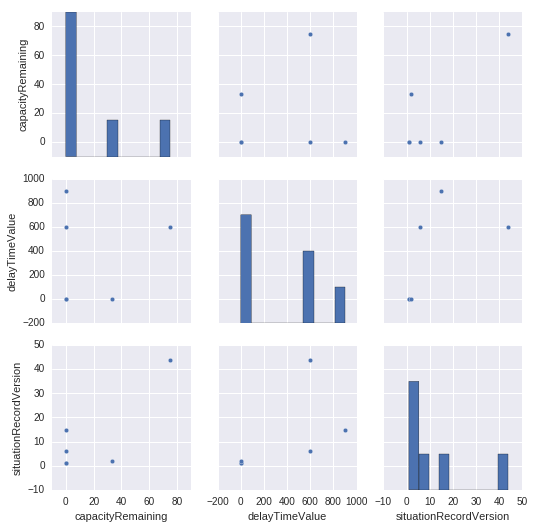

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(datanew)
plt.show()